In [1]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
import pyntcloud
from pyntcloud import PyntCloud
import scipy
from sklearn.neighbors import NearestNeighbors
print("Environment Ready")

# %matplotlib
%load_ext autoreload
%autoreload 2

Environment Ready


Frames Captured


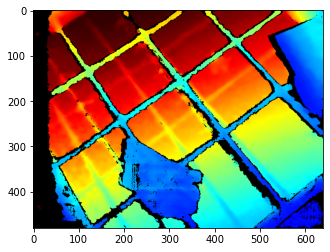

In [22]:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file("data/shadow_with_objects.bag")
profile = pipe.start(cfg)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for x in range(120):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured")
color = np.asanyarray(color_frame.get_data())
# plt.rcParams["axes.grid"] = False
# plt.rcParams['figure.figsize'] = [12, 6]
# plt.imshow(color)

colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
images = np.hstack((color,colorized_depth))
plt.imshow(colorized_depth)

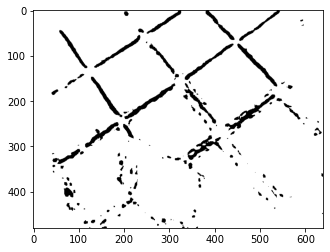

In [38]:
depth_blue = colorized_depth[:,:,:]/255.1
depth_blur = cv2.GaussianBlur(depth_blue,(9,9),cv2.BORDER_DEFAULT)
depth_laplacian = cv2.Laplacian(depth_blur,cv2.CV_64F)
depth_laplacian = (depth_laplacian - depth_laplacian.min())
depth_laplacian = depth_laplacian/depth_laplacian.max()
depth_laplacian_cp = np.ones_like(depth_laplacian)
depth_laplacian_cp[(depth_laplacian>0.4)&(depth_laplacian<0.6)]=0
gray = np.mean(depth_laplacian_cp,axis=2)
gray = cv2.GaussianBlur(gray,(9,9),cv2.BORDER_DEFAULT)
gray = gray/gray.max()

gray_lowpass = cv2.GaussianBlur(gray,(9,9),cv2.BORDER_DEFAULT)
# gray = gray - gray_lowpass
gray = (gray-gray.min())/(gray.max()-gray.min())
th = 0.4
gray[gray>th]=1
gray[gray<th]=0
gray = gray.astype(np.bool)
plt.imshow(gray,cmap=plt.cm.binary)
# plt.plot([0,600],[0,400],color='red')



ValueError: Found array with dim 3. Estimator expected <= 2.

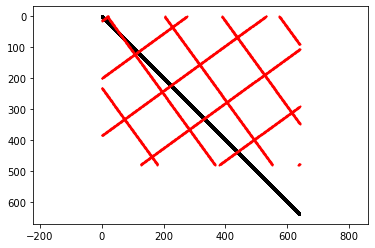

In [39]:
p0 = np.array([-70,-120])
dn = 150;dt =150
al = np.pi*0.3; 
H,W = gray.shape

def image2points(gray):
    H,W = gray.shape
    ind_x = np.array([range(W) for _ in range(H)])
    ind_y = np.array([range(H) for _ in range(W)]).T
    x = ind_x[gray]
    y = ind_y[gray]
    return np.vstack((x,y))

def generateLines(p0,dn,al,H,W):
    tmax =  (np.linalg.norm([H,W]) + 2*dn).astype(np.int)
    if al>=0:
        t = np.arange(tmax)
    elif al<0:
        t = np.arange(-tmax//2,tmax//2)
    kmax = max(H//dn,W//dn)+3
    x = np.array([]);y = np.array([])
    for k in range(-kmax,kmax):
        xnew = p0[0] - np.sin(al)*dn*k + np.cos(al)*t
        ynew = p0[1] + np.cos(al)*dn*k + np.sin(al)*t
        x = np.append(x,xnew)
        y = np.append(y,ynew)
    ind = (x>0) & (x<W) & (y>0) & (y<H)
    p = np.vstack((x[ind],y[ind]))
    
    return p

line1 = generateLines(p0,dn,al,H,W)
line2 = generateLines(p0,dt,al-np.pi/2,H,W)
grid = np.hstack((line1,line2))

rebar = image2points(gray)
plt.scatter(rebar[0,:],rebar[1,:],s=1,c='k')
plt.scatter(grid[0,:],grid[1,:],s=1,c='r')


plt.axis('equal')
ax = plt.gca()
_,_ = ax.set_ylim(ax.get_ylim()[::-1])

n_neighbors = rebar.shape[1]
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree',metric='euclidean').fit(rebar.T)
distances, indices = nbrs.kneighbors(grid.T)

In [37]:
dist_toClosest = np.min(distances,axis=0)
dist_mean = np.mean(dist_toClosest)
# plt.plot(dist_toClosest)
print(dist_mean)

168.2720639139356


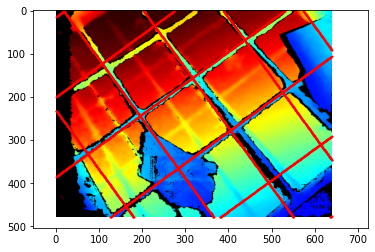

In [26]:
plt.imshow(colorized_depth)
plt.scatter(grid[0,:],grid[1,:],s=1,c='r')
_,_,_,_ = plt.axis('equal')